In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable
import sklearn
from sklearn.preprocessing import StandardScaler
from fastprogress import master_bar, progress_bar
from math import sqrt
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random

torch.manual_seed(0)

In [2]:
torch.cuda.is_available()

True

In [3]:
file_path_w = "input_data/input_data_weather.xlsx"

file_path_blast = "input_data/input_data_blasting.xlsx"

df_w = pd.read_excel(file_path_w, index_col = "Date")
df_b = pd.read_excel(file_path_blast, parse_dates=["Date"])

In [4]:
model_data_w = df_w

model_data_w.values.shape

(3653, 2)

In [5]:
df_b.values.shape

(44, 11)

In [6]:
def transform_data_w(arr, seq_len_in, seq_len_out, input_size):
    x, y = [], []
    
    for i in range(len(arr)-(seq_len_in+seq_len_out)): # len(df)-(seq_len_in+seq_len_out)
        
        x_i = arr[i : i+seq_len_in+1, 1:input_size+1]  # 
        y_i = arr[i + seq_len_in : i + seq_len_in + seq_len_out,0]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len_in+1, input_size).astype("float32")
    y_arr = np.array(y).reshape(-1, seq_len_out).astype("float32")
    x_var = Variable(torch.from_numpy(x_arr))
    y_var = Variable(torch.from_numpy(y_arr))
    return x_var, y_var

# nejde od nečega do ite vrijednosti u nizu, nego od datuma interesa - 100 dana, do datuma interesa, 
# hard-codea se datum interesa, 
# umjesto i, i onda nebu svaki outa drugi niz brojeva

In [7]:
class Blasting_dataset(Dataset):
    def __init__(self):
        # data laoding
        arr_w = pd.read_excel("input_data/input_data_weather.xlsx", index_col = "Date").values
        arr_b = pd.read_excel("input_data/input_data_blasting.xlsx", parse_dates=["Date"]).values
        
        self_x_b = torc.from_numpy(arr_b[:, 3:]) 
        
        
        self.x_w = torch.from_numpy(arr_w) 

####

Sve u jedan dataset, iz drugog, ide jedan po jedan redak, gleda datum, to mu je krajnji datum koji gleda u prvo setu,
zatim iz prvog seta uzme vrijednosti -100 od toga datuma i do njega, te njih provrti kroz LSTM, te torch.cat sa drugim podacima i pusti kroz dense layere (2-3)

In [8]:
def train_val_test_split(train_end_idx =27, 
                         val_start_idx=27, 
                         test_start_idx=33,
                         seq_len_in=1, seq_len_out=1, input_size=1):
        
        df_w = pd.read_excel("input_data/input_data_weather_2.xlsx", index_col = "Date")
        df_b = pd.read_excel("input_data/input_data_blasting.xlsx", parse_dates=["Date"])
        
        
        w_scaler, df_scaler, b_scaler = StandardScaler(), StandardScaler(), StandardScaler()
        
        df_train_b = df_b.iloc[:train_end_idx]
        print (df_train_b)
        df_valid_b = df_b.iloc[val_start_idx:test_start_idx]
        print (df_valid_b)
        df_test_b =  df_b.iloc[test_start_idx:]
        
        df_train_w = df_w.loc[df_train_b["Date"].iloc[0]-pd.Timedelta(days=200):df_train_b["Date"].iloc[0]]
        df_valid_w = df_w.loc[df_valid_b["Date"].iloc[0]-pd.Timedelta(days=200):df_valid_b["Date"].iloc[0]]
        df_test_w = df_w.loc[df_test_b["Date"].iloc[0]-pd.Timedelta(days=200):df_test_b["Date"].iloc[0]]
                
        train_b_scaled = df_scaler.fit_transform(df_train_b.iloc[:, 1:]).astype(np.float32)
        valid_b_scaled = df_scaler.fit_transform(df_valid_b.iloc[:, 1:]).astype(np.float32)
        test_b_scaled = df_scaler.fit_transform(df_test_b.iloc[:, 1:]).astype(np.float32)
        
        _ = b_scaler.fit(np.array(df_train_b.iloc[:, 1:3]).reshape(-1,2))
        
        train_w_scaled = w_scaler.fit_transform(df_train_w)
        valid_w_scaled = w_scaler.fit_transform(df_valid_w)
        test_w_scaled = w_scaler.fit_transform(df_test_w)
        
        b_x_train, b_y_train = Variable(torch.from_numpy(train_b_scaled[:, 2:])), Variable(torch.from_numpy(train_b_scaled[:, :2]))
        b_x_valid, b_y_valid = Variable(torch.from_numpy(valid_b_scaled[:, 2:])), Variable(torch.from_numpy(valid_b_scaled[:, :2]))
        b_x_test, b_y_test = Variable(torch.from_numpy(test_b_scaled[:, 2:])), Variable(torch.from_numpy(test_b_scaled[:, :2]))
        
        train_b_ds = TensorDataset(b_x_train, b_y_train)
        valid_b_ds = TensorDataset(b_x_valid, b_y_valid)
        test_b_ds = TensorDataset(b_x_test, b_y_test)
        
        train_w_ds = Variable(torch.from_numpy(train_w_scaled)).repeat(len(b_x_train),1,1).float()
        valid_w_ds = Variable(torch.from_numpy(train_w_scaled)).repeat(len(b_x_valid),1,1).float()
        test_w_ds = Variable(torch.from_numpy(train_w_scaled)).repeat(len(b_x_test),1,1).float()
        
        train_loader_b = torch.utils.data.DataLoader(train_b_ds, num_workers=0)
        valid_loader_b = torch.utils.data.DataLoader(valid_b_ds, num_workers=0)
        test_loader_b = torch.utils.data.DataLoader(test_b_ds, num_workers=0)
        
        train_loader_w = torch.utils.data.DataLoader(train_w_ds, num_workers=0)
        valid_loader_w = torch.utils.data.DataLoader(valid_w_ds, num_workers=0)
        test_loader_w = torch.utils.data.DataLoader(test_w_ds, num_workers=0)

        return (train_loader_b, valid_loader_b, test_loader_b, train_loader_w, valid_loader_w, 
    test_loader_w, df_scaler, b_scaler, test_b_ds, test_w_ds, valid_w_ds, valid_b_ds, train_w_ds, train_b_ds)
    
    
(train_loader_b, valid_loader_b, test_loader_b, train_loader_w, valid_loader_w, 
 test_loader_w, df_scaler, b_scaler, test_b_ds, test_w_ds, valid_w_ds, valid_b_ds, train_w_ds, train_b_ds) = train_val_test_split()

         Date  Explosive\nCharge Mass  Stemming Length  Borehole Depth  \
0  2014-06-12                    1.25              1.0            2.03   
1  2014-06-12                    0.50              1.0            2.09   
2  2014-06-12                    1.00              1.0            2.01   
3  2014-06-12                    0.80              1.0            1.98   
4  2014-06-12                    0.60              1.0            2.07   
5  2014-06-12                    0.40              1.0            1.94   
6  2014-06-12                    0.40              1.0            1.98   
7  2014-06-12                    0.60              1.0            1.94   
8  2014-06-12                    0.80              1.0            1.94   
9  2014-06-12                    1.00              1.0            2.02   
10 2016-07-20                    0.20              0.5            2.44   
11 2016-07-20                    0.20              0.5            2.52   
12 2016-07-20                    0.40 

In [9]:
print(test_b_ds)

In [10]:
x_example = next(iter(train_loader_b))
print (x_example) 


[tensor([[-0.7781, -0.4361,  1.8600,  1.8478,  1.8393,  1.8266,  0.7925,  1.0775]]), tensor([[2.3147, 1.3038]])]


In [11]:
x_example = next(iter(train_loader_w))
print (x_example.shape) 

torch.Size([1, 201, 8])


### Defining the model

In [12]:
class Clay_NN(nn.Module):
    def __init__(self, input_size_lstm, hidden_size_lstm, num_layers_lstm, device, input_size_b, dropout=0.3):
        super(Clay_NN, self).__init__()
        # Initializing the model parameters
        self.input_size_lstm = input_size_lstm
        self.hidden_size_lstm = hidden_size_lstm
        self.num_layers_lstm = num_layers_lstm
        self.input_b = input_size_b
        self.device = device
        # Layer 1: LSTM # batch_size first ()
        self.lstm = nn.LSTM(self.input_size_lstm, self.hidden_size_lstm, 
                            self.num_layers_lstm, batch_first = True, dropout=dropout)
        # Layer 2: Fully coneccted (linear) layer
        self.linear_lstm = nn.Linear(self.hidden_size_lstm, 1)
        # Relu activation after LSTM
        self.relu1 = nn.ReLU()
        # Fully coneccted (linear) layer 1 - blasting data
        self.linear_b1 = nn.Linear(1+self.input_b, 5)
        # Relu activation after 1st fully connected
        self.relu2 = nn.ReLU()
        # Fully coneccted (linear) layer 1 - blasting data
        self.linear_b2 = nn.Linear(5, 2)
        
    def forward(self, input_w, input_b, prints = False):
        # Reshaping the input_seq
        input_w = input_w.view(-1, input_w.shape[1], self.input_size_lstm)
        if prints: print("input_seq shape:", input_w.shape, "->[num_batches, seq_len, num_features]")     
        # LSTM 
        output_lstm, (h_state, c_state) = self.lstm(input_w)
        if prints: print("LSTM: output shape:" , output_lstm.shape, "->[num_batches, seq_len, hidden_size]", 
                         "\n " "LSTM: h_state shape:", h_state.shape, 
                          "->[num_layers*num_directions, num_batches, hidden_size]", "\n"
                          "LSTM: c_state shape:", c_state.shape, 
                          "->[num_layers*num_directions, num_batches, hidden_size]")
        # Reshape 
        output_lstm = output_lstm[:, -1, :]
        if prints: print("Output reshaped:", output_lstm.shape, "->[num_batches, hidden_size]")
        # Fully connected layer
        output_lstm = self.linear_lstm(output_lstm)
        # Relu activation
        output_lstm = self.relu1(output_lstm)
        # Adding blasting data
        if prints: print ("LSTM: output shape:", output_lstm.shape)
        output = torch.cat((output_lstm, input_b), dim=1)        
        # Blasting layer 1
        output = self.linear_b1(output)
        # Relu activation
        output = self.relu2(output)
        # Blasting layer 2
        output = self.linear_b2(output)
        
        if prints: print("FNN: Final output shape:", output.shape, "->[num_batches, num_features]")
        return output

In [13]:
def create_model(save_dir, input_size, hidden_size, num_layers, seq_len_out, architecture = "LSTM", device = "cpu", dropout = 0.1):
    if os.path.exists(save_dir):
        if architecture == "LSTM":
            model = LSTM(input_size, hidden_size, num_layers, seq_len_out, device)
        else:
            model = RNN(input_size, hidden_size, num_layers, seq_len_out, device)
        model, prev_epochs, optimizer = model_loader(save_dir)
        return model, prev_epochs, optimizer
    else:
        if architecture == "LSTM":
            model = LSTM(input_size, hidden_size, num_layers, seq_len_out, device)
        else:
            model = RNN(input_size, hidden_size, num_layers, seq_len_out, device)
        prev_epochs = 0
        return model, prev_epochs

In [14]:
def save_model(checkpoint, save_dir):
    """
    Saving: model, optimizer, epochs, state dict
    """
    print ("Model has been saved.")
    return torch.save(checkpoint, save_dir)


In [15]:
def model_loader(file_pth, device = "cpu"):
    """
    The function loads a checkpoint from the model. Either to continue
    training, or for inference.
    """
    checkpoint = torch.load(file_pth)
    model = checkpoint["model"]
    model.load_state_dict(checkpoint["model_state"])
    optimizer = checkpoint["optimizer_state"]
    prev_epochs = checkpoint["epoch"]
    
    return model, prev_epochs

In [157]:
# defining the metrics  
def get_metrics(predicted, observed, label = "Train"):
    if len(predicted) == len (observed):
        nse = 1-(np.sum(np.square(predicted - observed))/np.sum(np.square(observed - np.mean(observed))))
        mse = 1/len(predicted)*np.sum(np.square(observed-predicted))
        rmse = np.sqrt(mse)
        ss_res=np.square(np.sum((observed-np.mean(observed))*(predicted-np.mean(predicted))))
        print (ss_res)
        ss_tot=np.sum(np.square(observed-np.mean(observed)))*np.sum(np.square(predicted-np.mean(predicted)))  
        print (ss_tot)
        r2 = ss_res/ss_tot
        mae = np.sum(np.absolute(predicted-observed))/len(predicted)
        rse = np.sum(np.square(observed - predicted)) / np.sum(np.square(observed - np.mean(observed)))
        rae = np.sum(np.abs(observed - predicted)) / np.sum(np.abs(observed - np.mean(observed)))
        mbe = (np.sum(predicted - observed))/len(predicted)
        mre = np.max(observed - predicted)
        
        # leverage
        model1 = sm.OLS(predicted, observed).fit()
        influence = model1.get_influence()
        inf_sum = influence.summary_frame()
        student_resid = influence.resid_studentized_external
        (cooks, p) = influence.cooks_distance
        (dffits, p) = influence.dffits
        leverage = influence.hat_matrix_diag
        print ("Leverage values:", leverage)
        
        # definingthe resiudal vs. leverage plot

        plt.scatter (leverage, model1.resid_pearson, s = 60, label = label)
        plt.title('Leverage vs. Studentized Residuals', fontsize = 20)
        plt.xlabel('Leverage', size=20,)
        plt.ylabel('Studentized Residuals', size = 20)
        plt.tick_params(grid_alpha=0.9, labelsize=17)
        plt.legend(fontsize=19,)


        
        
        metrics = {"MSE": mse, "RMSE":rmse, "NSE":nse, "R2":r2, "MAE":mae, 
                   "RAE":rae, "RSE":rse, "MBE":mbe, "MRE":mre}

        return metrics

In [80]:
# function to plot the loss during training
def plot_loss(epochs, train_loss, test_loss):
    plt.figure(figsize=[12., 6.])
    plt.plot(epochs, train_loss, label = "Training Loss")
    plt.plot(epochs, test_loss, label = "Validation Loss")
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show() 

In [18]:
def train_network(model, train_loader_b, valid_loader_b, train_loader_w, valid_loader_w, prev_epochs = 0, num_epochs = 5,
                  num_batches = 64, learning_rate = 0.001, device = "cpu"):
    """Trains the model and compztes the average accuracy for train and tesat data."""
    print("Get data ready...")
    print ("The model was trained for {} epochs, and will be trained for {} new epochs.".format(prev_epochs, num_epochs))
    # get number of new epochs to train for
    new_epochs = prev_epochs + num_epochs
    
    # Create Criterion and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adamax(model.parameters(), lr = learning_rate)
    
    print ("Training started...")
    # Train the data multiple times
    
    loss_vals_train = []
    loss_vals_test = []
    epoch = 0
    for epoch in progress_bar(range(prev_epochs, new_epochs)):
        train_loss = 0
        test_loss = 0
        print ("Epoch {}/{}".format(epoch+1, new_epochs))
        print ("-" * 20)
        
        # Set the model to training mode
        model.train()
        model.to(device)
        
        for k, (x_b, y_b) in enumerate(train_loader_b): # k je iteracija -- > if k % 1 == 0: print ....
            for j, x_w in enumerate(train_loader_w):
                x_b, y_b = x_b.to(device), y_b.to(device)
                x_w = x_w.to(device)

                # geting the outputs of the network
                out = model(x_w, x_b)

                # Clear the gradients from the prviuos iteration
                optimizer.zero_grad()

                # Compute the loss
                loss = criterion(out, y_b)

                # Compute the gradients for the neurons
                loss.backward()
                # Save Loss after each iteration
                train_loss += loss.item()
                # Update the weights
                optimizer.step()

        loss_vals_train.append(train_loss/len(train_loader_b))
        # Print Loss per training epoch   
        print("TRAIN | MSE: {:.3f} | RMSE: {:.3f}".format(train_loss/k, sqrt(train_loss/k)))

        # Put the model into evaluation mode
        model.eval()

        for k, (x_b, y_b) in enumerate(valid_loader_b):
            for j, x_w in enumerate(valid_loader_w):
                x_b, y_b = x_b.to(device), y_b.to(device)
                x_w = x_w.to(device)
                # getiong the outputs of the network
                out = model(x_w, x_b)
                # Compute the loss
                loss = criterion(out, y_b)
                test_loss += loss.item()



        loss_vals_test.append(test_loss/len(valid_loader_b))
        print("TEST | MSE: {:.3f} | RMSE: {:.3f}".format(test_loss/k, sqrt(test_loss/k)))


    plot_loss(range(prev_epochs, new_epochs), loss_vals_train, loss_vals_test)

    checkpoint = {"model": model,
                  "epoch": epoch+1,
                  "model_state": model.state_dict(),
                  "optimizer_state": optimizer.state_dict(),
                 }

    return checkpoint



In [135]:
input_size_lstm = 2
hidden_size_lstm = 120
num_layers_lstm = 2
device = "cuda"
input_size_b = 8
save_dir = "clay_model_1.1.pth"
num_epochs = 10
num_batches = 4
learning_rate = 0.00005

torch.manual_seed(14)
random.seed(14)
np.random.seed(14)

if os.path.exists(save_dir):
    clay_nn = Clay_NN(input_size_lstm, hidden_size_lstm, num_layers_lstm, device, input_size_b, )
    clay_nn, prev_epochs = model_loader(save_dir)
else:
    clay_nn = Clay_NN(input_size_lstm, hidden_size_lstm, num_layers_lstm, device, input_size_b, )
    prev_epochs = 0




Get data ready...
The model was trained for 50 epochs, and will be trained for 10 new epochs.
Training started...


Epoch 51/60
--------------------
TRAIN | MSE: 10.343 | RMSE: 3.216
TEST | MSE: 2.648 | RMSE: 1.627
Epoch 52/60
--------------------
TRAIN | MSE: 10.343 | RMSE: 3.216
TEST | MSE: 2.644 | RMSE: 1.626
Epoch 53/60
--------------------
TRAIN | MSE: 10.275 | RMSE: 3.205
TEST | MSE: 2.642 | RMSE: 1.625
Epoch 54/60
--------------------
TRAIN | MSE: 10.210 | RMSE: 3.195
TEST | MSE: 2.641 | RMSE: 1.625
Epoch 55/60
--------------------
TRAIN | MSE: 10.133 | RMSE: 3.183
TEST | MSE: 2.639 | RMSE: 1.625
Epoch 56/60
--------------------
TRAIN | MSE: 10.055 | RMSE: 3.171
TEST | MSE: 2.641 | RMSE: 1.625
Epoch 57/60
--------------------
TRAIN | MSE: 9.995 | RMSE: 3.161
TEST | MSE: 2.645 | RMSE: 1.626
Epoch 58/60
--------------------
TRAIN | MSE: 9.929 | RMSE: 3.151
TEST | MSE: 2.650 | RMSE: 1.628
Epoch 59/60
--------------------
TRAIN | MSE: 9.858 | RMSE: 3.140
TEST | MSE: 2.656 | RMSE: 1.630
Epoch 60/60
--------------------
TRAIN | MSE: 9.781 | RMSE: 3.127
TEST | MSE: 2.667 | RMSE: 1.633


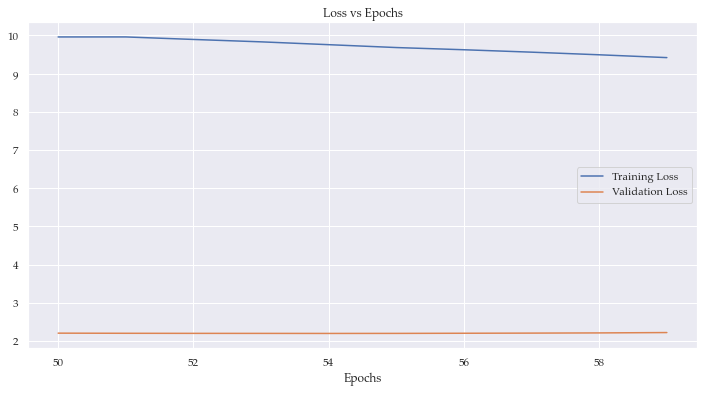

Model has been saved.


In [143]:

    
checkpoint = train_network(clay_nn, train_loader_b, valid_loader_b, train_loader_w, valid_loader_w, 
                           prev_epochs=prev_epochs, num_epochs=num_epochs, 
                           num_batches= num_batches, learning_rate = learning_rate, device = device);

save_model(checkpoint, save_dir)

In [136]:
def make_prediction(test_w_ds, test_b_ds, model, b_scaler):
    clay_nn.to("cpu")
    clay_nn.eval()
    predicted_list = list()
    with torch.no_grad():
        for i in range(len(test_b_ds)):
            item_w = test_w_ds[i].view(1,-1, 2)
            item_b = test_b_ds[i][0].view(1, -1)
            predicted = clay_nn(item_w, item_b).cpu()
            predicted_list.append(b_scaler.inverse_transform(predicted))
            
    # converting tensor to arrays
    results_df = pd.DataFrame(np.array(predicted_list).reshape(-1,2), columns = ["ECM_pred", "Stemming_len_pred"])
    # deti da provjerava broj columnsa, koliko je broj predviđenih varijabli
    #results_df["predicted"]= predicted_list


    #observed = b_scaler.inverse_transform(observed_data.numpy()[:,0])      
    # plot simple line chart
    #plot_results(observed[:], predicted[:])
    
    return results_df

In [137]:
results_df_test = make_prediction(test_w_ds, test_b_ds, clay_nn, b_scaler) 

In [138]:
results_df_valid = make_prediction(valid_w_ds, valid_b_ds, clay_nn, b_scaler) 

In [139]:
results_df_train = make_prediction(train_w_ds, train_b_ds, clay_nn, b_scaler) 

In [140]:
results_df_valid

,ECM_pred,Stemming_len_pred
0,1.110385,0.729024
1,0.324973,0.532053
2,0.442528,0.552090
3,0.685554,0.878933
4,0.489728,0.955343
5,0.419448,0.536667


In [141]:
results_df_test

,ECM_pred,Stemming_len_pred
0,0.110673,0.806142
1,0.439042,0.549761
2,0.535468,0.614194
3,0.657149,0.659105
4,1.019242,0.669929
5,0.144072,0.509130
6,0.359050,0.559319
7,0.810749,0.804983
8,0.797136,0.745625
9,0.801369,0.723216


In [142]:
results_df_train

,ECM_pred,Stemming_len_pred
0,0.986322,0.979730
1,0.491884,0.790632
2,0.944614,0.934580
3,0.772622,0.906906
4,0.653975,0.855452
5,0.530912,1.000730
6,0.381684,0.854511
7,0.536163,0.993477
8,0.849458,0.946869
9,1.029827,0.925055


In [143]:
predicted_data_df = pd.concat([results_df_valid, results_df_test, results_df_train], axis = 0)
predicted_data_df

,ECM_pred,Stemming_len_pred
0,1.110385,0.729024
1,0.324973,0.532053
2,0.442528,0.552090
3,0.685554,0.878933
4,0.489728,0.955343
5,0.419448,0.536667
0,0.110673,0.806142
1,0.439042,0.549761
2,0.535468,0.614194
3,0.657149,0.659105


In [156]:
len(predicted_data_df)

44

## Creating data for visualizations

### Blasting data - observed

In [144]:
test_data_blasting = df_b.loc[df_b["Date"] == "2016-08-31"].reset_index().iloc[:, 1:]

valid_data_blasting = df_b.loc[df_b["Date"] == "2015-06-12"].reset_index().iloc[:, 1:]

train_data_blasting = df_b.loc[((df_b["Date"] == "2014-06-12") | (df_b["Date"] == "2016-07-20") )].reset_index().iloc[:, 1:]

observed_data_df = pd.concat([valid_data_blasting, test_data_blasting, train_data_blasting], axis = 0)

observed_data_df


,Date,Explosive\nCharge Mass,Stemming Length,Borehole Depth,Dubina minske bušotine nakon miniranja,Volumen nastalog proširenja,Volumen cijele minske bušotine,Volumen nastalog proširenja.1,Volumen cijele minske bušotine.1,Produbljenje,Proširenje
0,2015-06-12,1.60,1.00,3.07,3.58,807.00,844.50,0.80700,0.84450,0.51,1.169
1,2015-06-12,0.20,0.30,3.04,3.20,80.50,111.50,0.08050,0.11150,0.16,0.584
2,2015-06-12,0.40,0.30,3.05,3.28,154.50,188.00,0.15450,0.18800,0.23,0.670
3,2015-06-12,0.80,0.50,2.87,3.20,393.50,417.40,0.39350,0.41740,0.33,0.953
4,2015-06-12,0.60,0.50,2.80,3.05,255.50,281.00,0.25550,0.28100,0.25,0.783
5,2015-06-12,0.40,0.50,3.07,3.30,113.50,151.00,0.11350,0.15100,0.23,0.693
0,2016-08-31,0.20,0.50,2.05,2.30,117.50,138.00,0.11750,0.13800,0.25,0.601
1,2016-08-31,0.40,0.50,2.10,2.50,298.00,317.50,0.29800,0.31750,0.40,0.848
2,2016-08-31,0.60,0.50,2.10,2.50,378.50,399.00,0.37850,0.39900,0.40,1.088
3,2016-08-31,0.80,0.50,2.10,2.50,519.00,542.00,0.51900,0.54200,0.40,1.060


In [145]:
df_b 

,Date,Explosive\nCharge Mass,Stemming Length,Borehole Depth,Dubina minske bušotine nakon miniranja,Volumen nastalog proširenja,Volumen cijele minske bušotine,Volumen nastalog proširenja.1,Volumen cijele minske bušotine.1,Produbljenje,Proširenje
0,2014-06-12,1.25,1.00,2.03,2.43,872.20,883.80,0.87220,0.88380,0.40,1.193
1,2014-06-12,0.50,1.00,2.09,2.36,371.65,395.20,0.37165,0.39520,0.27,1.006
2,2014-06-12,1.00,1.00,2.01,2.44,751.65,758.90,0.75165,0.75890,0.43,1.254
3,2014-06-12,0.80,1.00,1.98,2.38,574.70,589.20,0.57470,0.58920,0.40,1.169
4,2014-06-12,0.60,1.00,2.07,2.41,507.10,523.05,0.50710,0.52305,0.34,1.153
5,2014-06-12,0.40,1.00,1.94,2.23,461.55,476.55,0.46155,0.47655,0.26,1.045
6,2014-06-12,0.40,1.00,1.98,2.20,323.00,335.50,0.32300,0.33550,0.22,0.881
7,2014-06-12,0.60,1.00,1.94,2.22,436.96,454.21,0.43696,0.45421,0.28,1.096
8,2014-06-12,0.80,1.00,1.94,2.36,656.95,669.20,0.65695,0.66920,0.42,1.129
9,2014-06-12,1.00,1.00,2.02,2.48,835.50,849.90,0.83550,0.84990,0.46,1.140


In [146]:
final_data_df = pd.concat([predicted_data_df, observed_data_df], axis = 1)
final_data_df

,ECM_pred,Stemming_len_pred,Date,Explosive\nCharge Mass,Stemming Length,Borehole Depth,Dubina minske bušotine nakon miniranja,Volumen nastalog proširenja,Volumen cijele minske bušotine,Volumen nastalog proširenja.1,Volumen cijele minske bušotine.1,Produbljenje,Proširenje
0,1.110385,0.729024,2015-06-12,1.60,1.00,3.07,3.58,807.00,844.50,0.80700,0.84450,0.51,1.169
1,0.324973,0.532053,2015-06-12,0.20,0.30,3.04,3.20,80.50,111.50,0.08050,0.11150,0.16,0.584
2,0.442528,0.552090,2015-06-12,0.40,0.30,3.05,3.28,154.50,188.00,0.15450,0.18800,0.23,0.670
3,0.685554,0.878933,2015-06-12,0.80,0.50,2.87,3.20,393.50,417.40,0.39350,0.41740,0.33,0.953
4,0.489728,0.955343,2015-06-12,0.60,0.50,2.80,3.05,255.50,281.00,0.25550,0.28100,0.25,0.783
5,0.419448,0.536667,2015-06-12,0.40,0.50,3.07,3.30,113.50,151.00,0.11350,0.15100,0.23,0.693
0,0.110673,0.806142,2016-08-31,0.20,0.50,2.05,2.30,117.50,138.00,0.11750,0.13800,0.25,0.601
1,0.439042,0.549761,2016-08-31,0.40,0.50,2.10,2.50,298.00,317.50,0.29800,0.31750,0.40,0.848
2,0.535468,0.614194,2016-08-31,0.60,0.50,2.10,2.50,378.50,399.00,0.37850,0.39900,0.40,1.088
3,0.657149,0.659105,2016-08-31,0.80,0.50,2.10,2.50,519.00,542.00,0.51900,0.54200,0.40,1.060


## Defining the scatter plots for model results

In [147]:
def plot_scatter_blasting(results_df, x_values, y_values_1, y_values_2, 
                          xlabel="Resulting Cavity [m$^3$]", ylabel="Explosive Charge Mass [kg]", model_number = "Model_1"):
    
    sns.set(font="Palatino Linotype")

    fig, ax = plt.subplots(figsize=(14,8), dpi=300)
    results_df["Date_formated"] = results_df["Date"].dt.strftime("%d.%m.%Y") 
        

    
    ax = sns.scatterplot(data = results_df, x=x_values, y=y_values_1,  s=250,  
                         label="Predicted", hue="Date_formated", style="Date_formated",  
                         markers=["p", "o", "X", "d"], palette = "Reds_r")
 
    ax = sns.scatterplot(data = results_df, x=x_values, y=y_values_2,  s=250,  
                         label="Observed", hue="Date_formated", style="Date_formated", 
                         markers=["p", "o", "X", "d"], palette = "ocean", alpha=0.8)
    

    ax.set_xlabel(xlabel, size=20,)
    ax.set_ylabel(ylabel, size=20)
    ax.tick_params(grid_alpha=0.9, labelsize=17)
    #plt.legend(fontsize=14)
    ax.legend(fontsize=19,)
    ax.set_title(model_number, fontsize = 20)
    #ax.set_xlim(-0.15, 0.95)

    plt.savefig("Figure_"+xlabel[:-4]+"_"+ ylabel[:-4]+".png", bbox_inches='tight')
    plt.show()
    
    
    
    
    
    

## Defining the model parameters for plotting

<ipython-input-147-30b1bb6f04f4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df["Date_formated"] = results_df["Date"].dt.strftime("%d.%m.%Y")


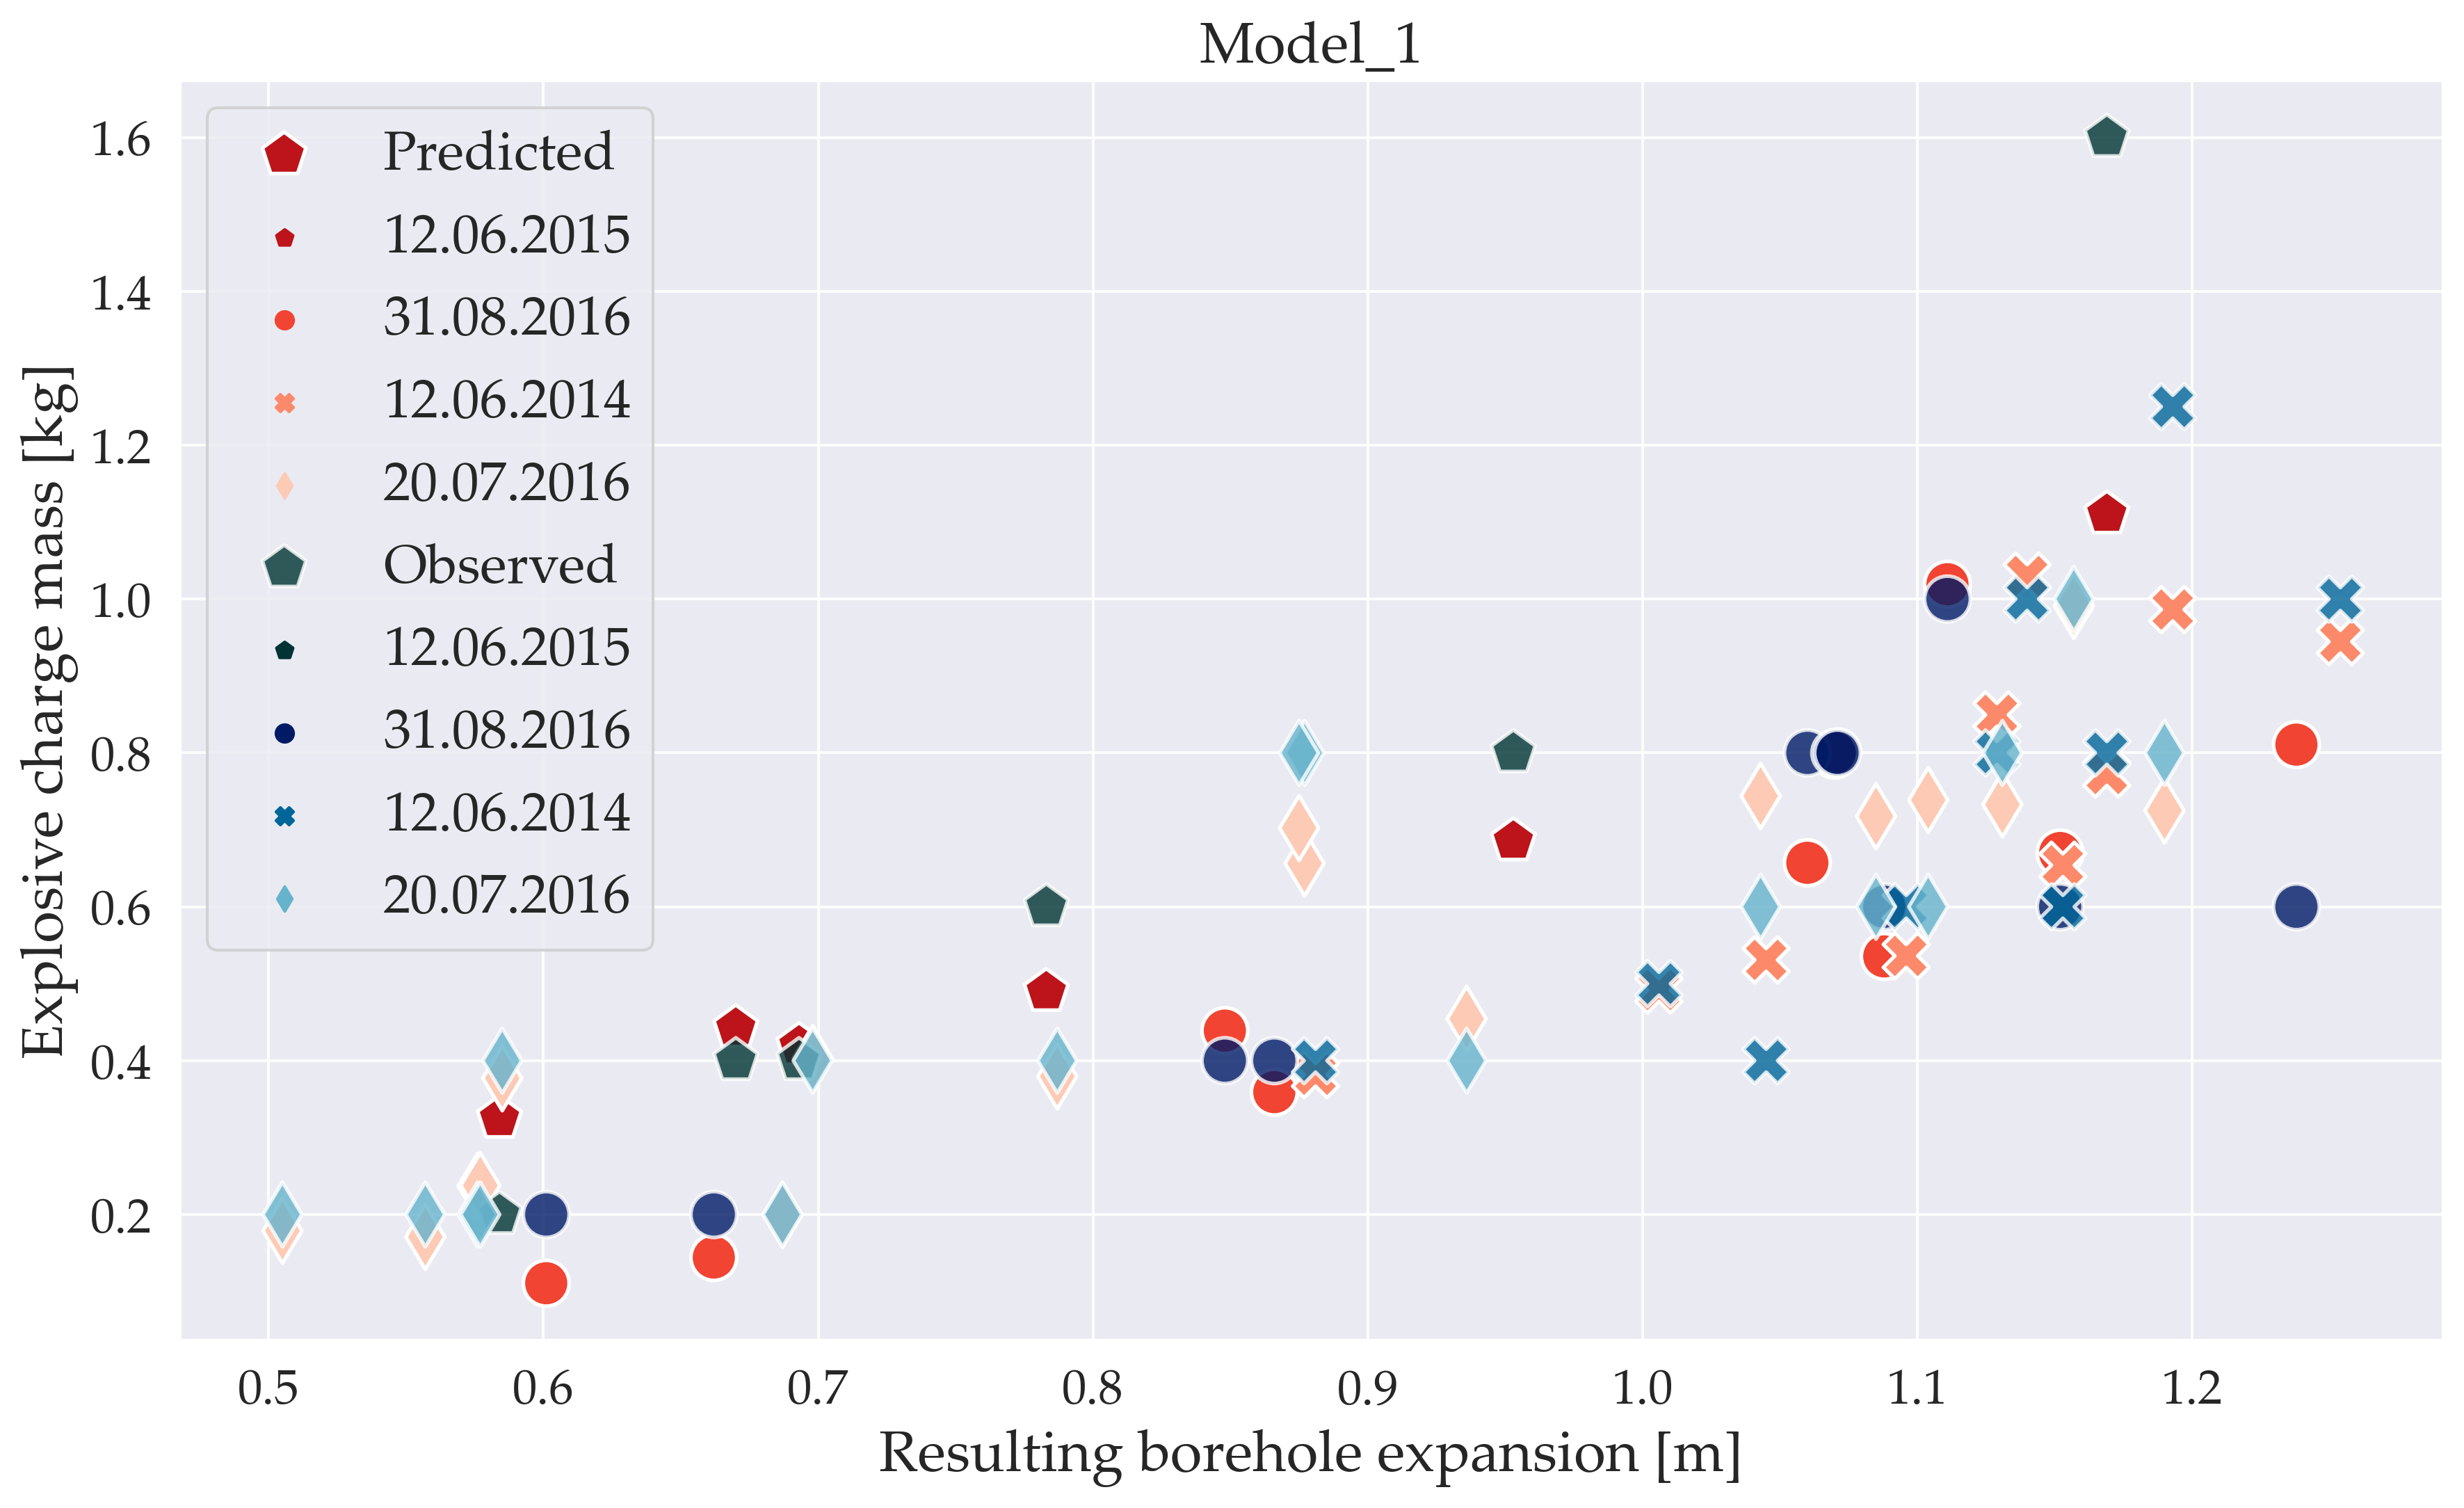

In [148]:
model_number = "Model_1"
x_values = "Proširenje"
y_values_1 = "ECM_pred"

y_values_2 = "Explosive\nCharge Mass"
xlabel = "Resulting borehole expansion [m]"
#xlabel = "Volume of the resulting Cavity [m$^3$]"
ylabel = "Explosive charge mass [kg]"
#ylabel = "Stemming legth [m]"

results_df = final_data_df[:]

plot_scatter_blasting(results_df, x_values, y_values_1, y_values_2, xlabel, ylabel, model_number=model_number)

In [149]:
results_df 

,ECM_pred,Stemming_len_pred,Date,Explosive\nCharge Mass,Stemming Length,Borehole Depth,Dubina minske bušotine nakon miniranja,Volumen nastalog proširenja,Volumen cijele minske bušotine,Volumen nastalog proširenja.1,Volumen cijele minske bušotine.1,Produbljenje,Proširenje,Date_formated
0,1.110385,0.729024,2015-06-12,1.60,1.00,3.07,3.58,807.00,844.50,0.80700,0.84450,0.51,1.169,12.06.2015
1,0.324973,0.532053,2015-06-12,0.20,0.30,3.04,3.20,80.50,111.50,0.08050,0.11150,0.16,0.584,12.06.2015
2,0.442528,0.552090,2015-06-12,0.40,0.30,3.05,3.28,154.50,188.00,0.15450,0.18800,0.23,0.670,12.06.2015
3,0.685554,0.878933,2015-06-12,0.80,0.50,2.87,3.20,393.50,417.40,0.39350,0.41740,0.33,0.953,12.06.2015
4,0.489728,0.955343,2015-06-12,0.60,0.50,2.80,3.05,255.50,281.00,0.25550,0.28100,0.25,0.783,12.06.2015
5,0.419448,0.536667,2015-06-12,0.40,0.50,3.07,3.30,113.50,151.00,0.11350,0.15100,0.23,0.693,12.06.2015
0,0.110673,0.806142,2016-08-31,0.20,0.50,2.05,2.30,117.50,138.00,0.11750,0.13800,0.25,0.601,31.08.2016
1,0.439042,0.549761,2016-08-31,0.40,0.50,2.10,2.50,298.00,317.50,0.29800,0.31750,0.40,0.848,31.08.2016
2,0.535468,0.614194,2016-08-31,0.60,0.50,2.10,2.50,378.50,399.00,0.37850,0.39900,0.40,1.088,31.08.2016
3,0.657149,0.659105,2016-08-31,0.80,0.50,2.10,2.50,519.00,542.00,0.51900,0.54200,0.40,1.060,31.08.2016


## Calculating metrics and results of modelling

In [150]:
final_data_df = final_data_df.iloc[:, :5]
final_data_df

,ECM_pred,Stemming_len_pred,Date,Explosive\nCharge Mass,Stemming Length
0,1.110385,0.729024,2015-06-12,1.60,1.00
1,0.324973,0.532053,2015-06-12,0.20,0.30
2,0.442528,0.552090,2015-06-12,0.40,0.30
3,0.685554,0.878933,2015-06-12,0.80,0.50
4,0.489728,0.955343,2015-06-12,0.60,0.50
5,0.419448,0.536667,2015-06-12,0.40,0.50
0,0.110673,0.806142,2016-08-31,0.20,0.50
1,0.439042,0.549761,2016-08-31,0.40,0.50
2,0.535468,0.614194,2016-08-31,0.60,0.50
3,0.657149,0.659105,2016-08-31,0.80,0.50


In [151]:
final_data_df["Date"] == "2016-07-20"

0     False
1     False
2     False
3     False
4     False
5     False
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
Name: Date, dtype: bool

0.0005662146396424563
0.003210767903111198
Leverage values: [0.09606517 0.09606517 0.09606517 0.09606517 0.09606517 0.09606517
 0.09606517 0.03934829 0.09606517 0.09606517 0.09606517]
0.006075946926743708
0.057385609522461876
Leverage values: [0.51813472 0.04663212 0.04663212 0.12953368 0.12953368 0.12953368]
1.0312186508660932
1.3686405839743436
Leverage values: [0.07017544 0.07017544 0.07017544 0.07017544 0.07017544 0.07017544
 0.07017544 0.07017544 0.07017544 0.07017544 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386 0.01754386
 0.01754386 0.01754386 0.01754386]


,MSE,RMSE,NSE,R2,MAE,RAE,RSE,MBE,MRE
0,0.052692,0.229547,-18.678182,0.176349,0.189151,6.357577,19.678182,0.189151,-0.009130
1,0.090516,0.300859,-0.654106,0.105879,0.271010,1.682134,1.654106,0.180685,0.270976
2,0.016212,0.127326,0.721919,0.753462,0.102734,0.440548,0.278081,0.030511,0.209368


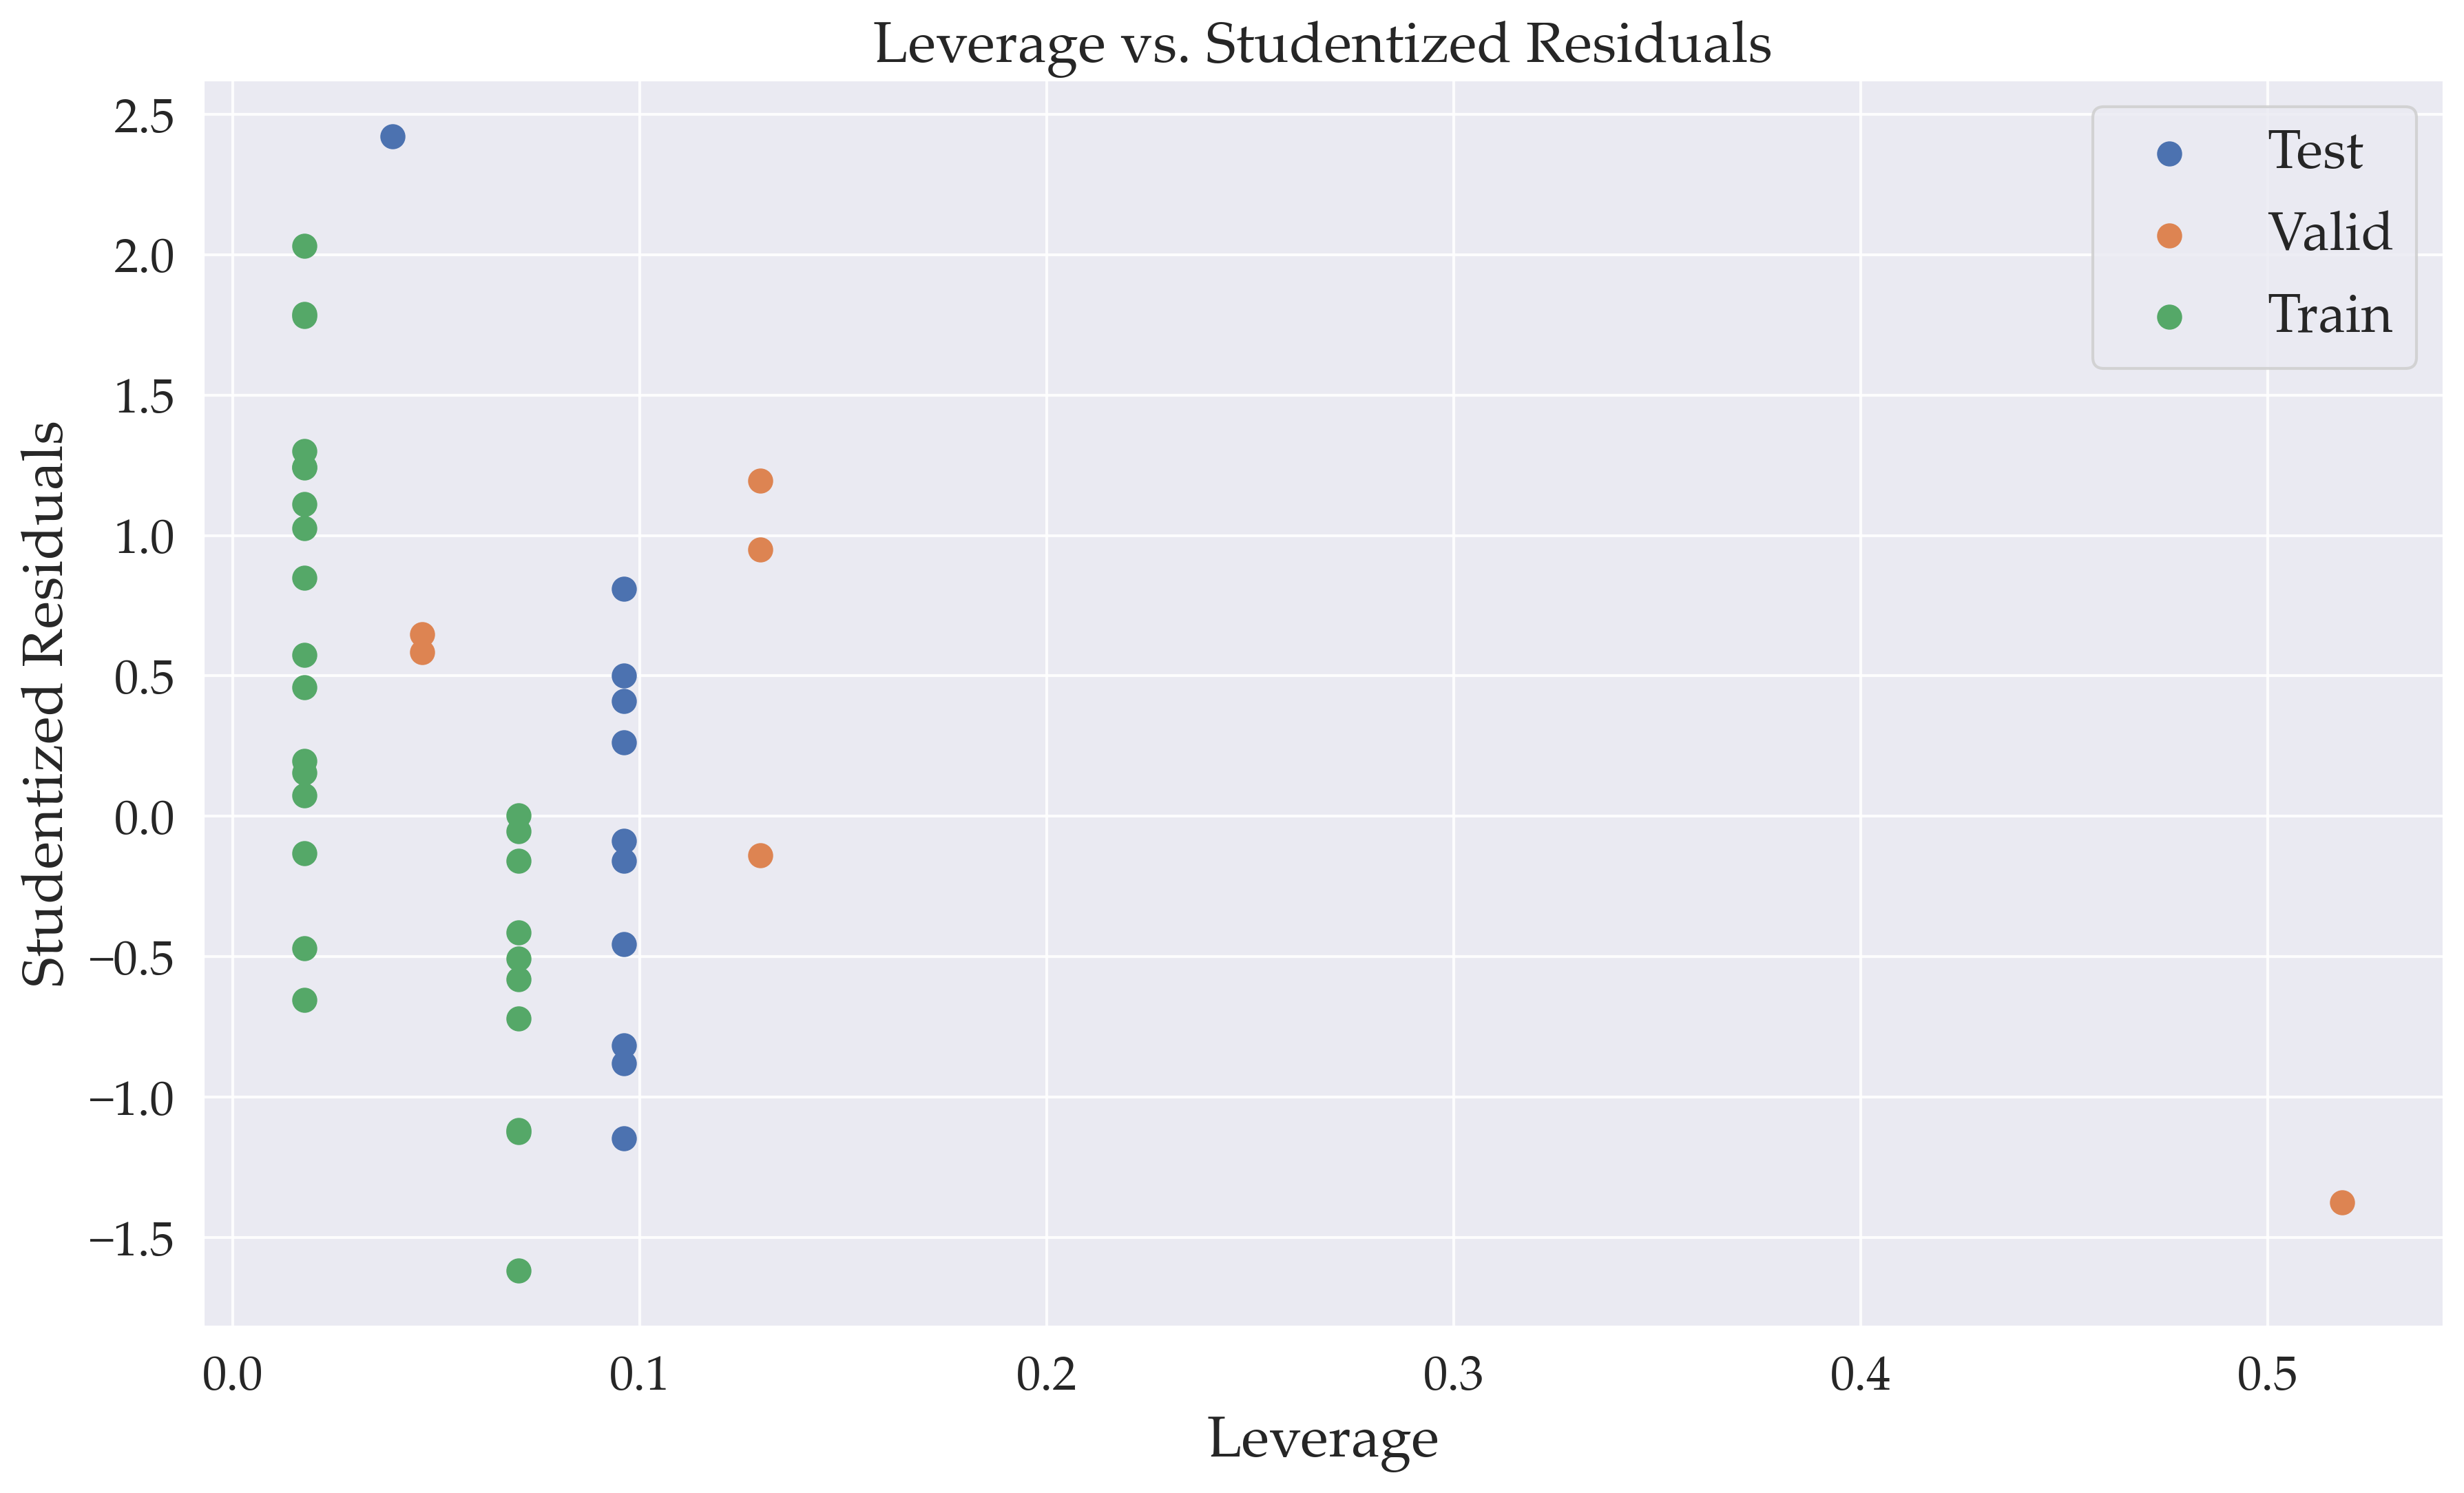

In [161]:
plt.figure(figsize=(14, 8), dpi=300)

stem_metrics_test = get_metrics(final_data_df.loc[final_data_df["Date"] == "2016-08-31"]["Stemming_len_pred"], 
                                final_data_df.loc[final_data_df["Date"] == "2016-08-31"]["Stemming Length"], "Test")

stem_metrics_valid = get_metrics(final_data_df.loc[final_data_df["Date"] == "2015-06-12"]["Stemming_len_pred"], 
                                final_data_df.loc[final_data_df["Date"] == "2015-06-12"]["Stemming Length"], "Valid")

stem_metrics_train = get_metrics(final_data_df.loc[((final_data_df["Date"] == "2014-06-12") | (final_data_df["Date"] == "2016-07-20") )]["Stemming_len_pred"], 
                                final_data_df.loc[((final_data_df["Date"] == "2014-06-12") | (final_data_df["Date"] == "2016-07-20") )]["Stemming Length"], "Train")

stem_metrics_df = pd.DataFrame.from_dict([stem_metrics_test, stem_metrics_valid, stem_metrics_train ],)

plt.savefig("Stem_leverage.png", dpi=300, bbox_inches='tight')
stem_metrics_df

0.5078742902647022
0.5662603751095858
Leverage values: [0.00909091 0.03636364 0.08181818 0.14545455 0.22727273 0.00909091
 0.03636364 0.08181818 0.14545455 0.14545455 0.08181818]
0.5092299814822077
0.5142476177215577
Leverage values: [0.65306122 0.01020408 0.04081633 0.16326531 0.09183673 0.04081633]
3.600241208857891
3.9586453750619177
Leverage values: [0.13455328 0.02152853 0.0861141  0.05511302 0.03100108 0.01377826
 0.01377826 0.03100108 0.05511302 0.0861141  0.00344456 0.00344456
 0.01377826 0.01377826 0.03100108 0.05511302 0.05511302 0.0861141
 0.01377826 0.00344456 0.03100108 0.05511302 0.03100108 0.05511302
 0.01377826 0.00344456 0.00344456]


,MSE,RMSE,NSE,R2,MAE,RAE,RSE,MBE,MRE
0,0.008051,0.089726,0.869068,0.896892,0.066975,0.326775,0.130932,-0.005107,0.142851
1,0.047131,0.217097,0.774373,0.990243,0.150214,0.422476,0.225627,-0.087897,0.489615
2,0.007532,0.086786,0.907149,0.909463,0.063706,0.269694,0.092851,-0.004664,0.263678


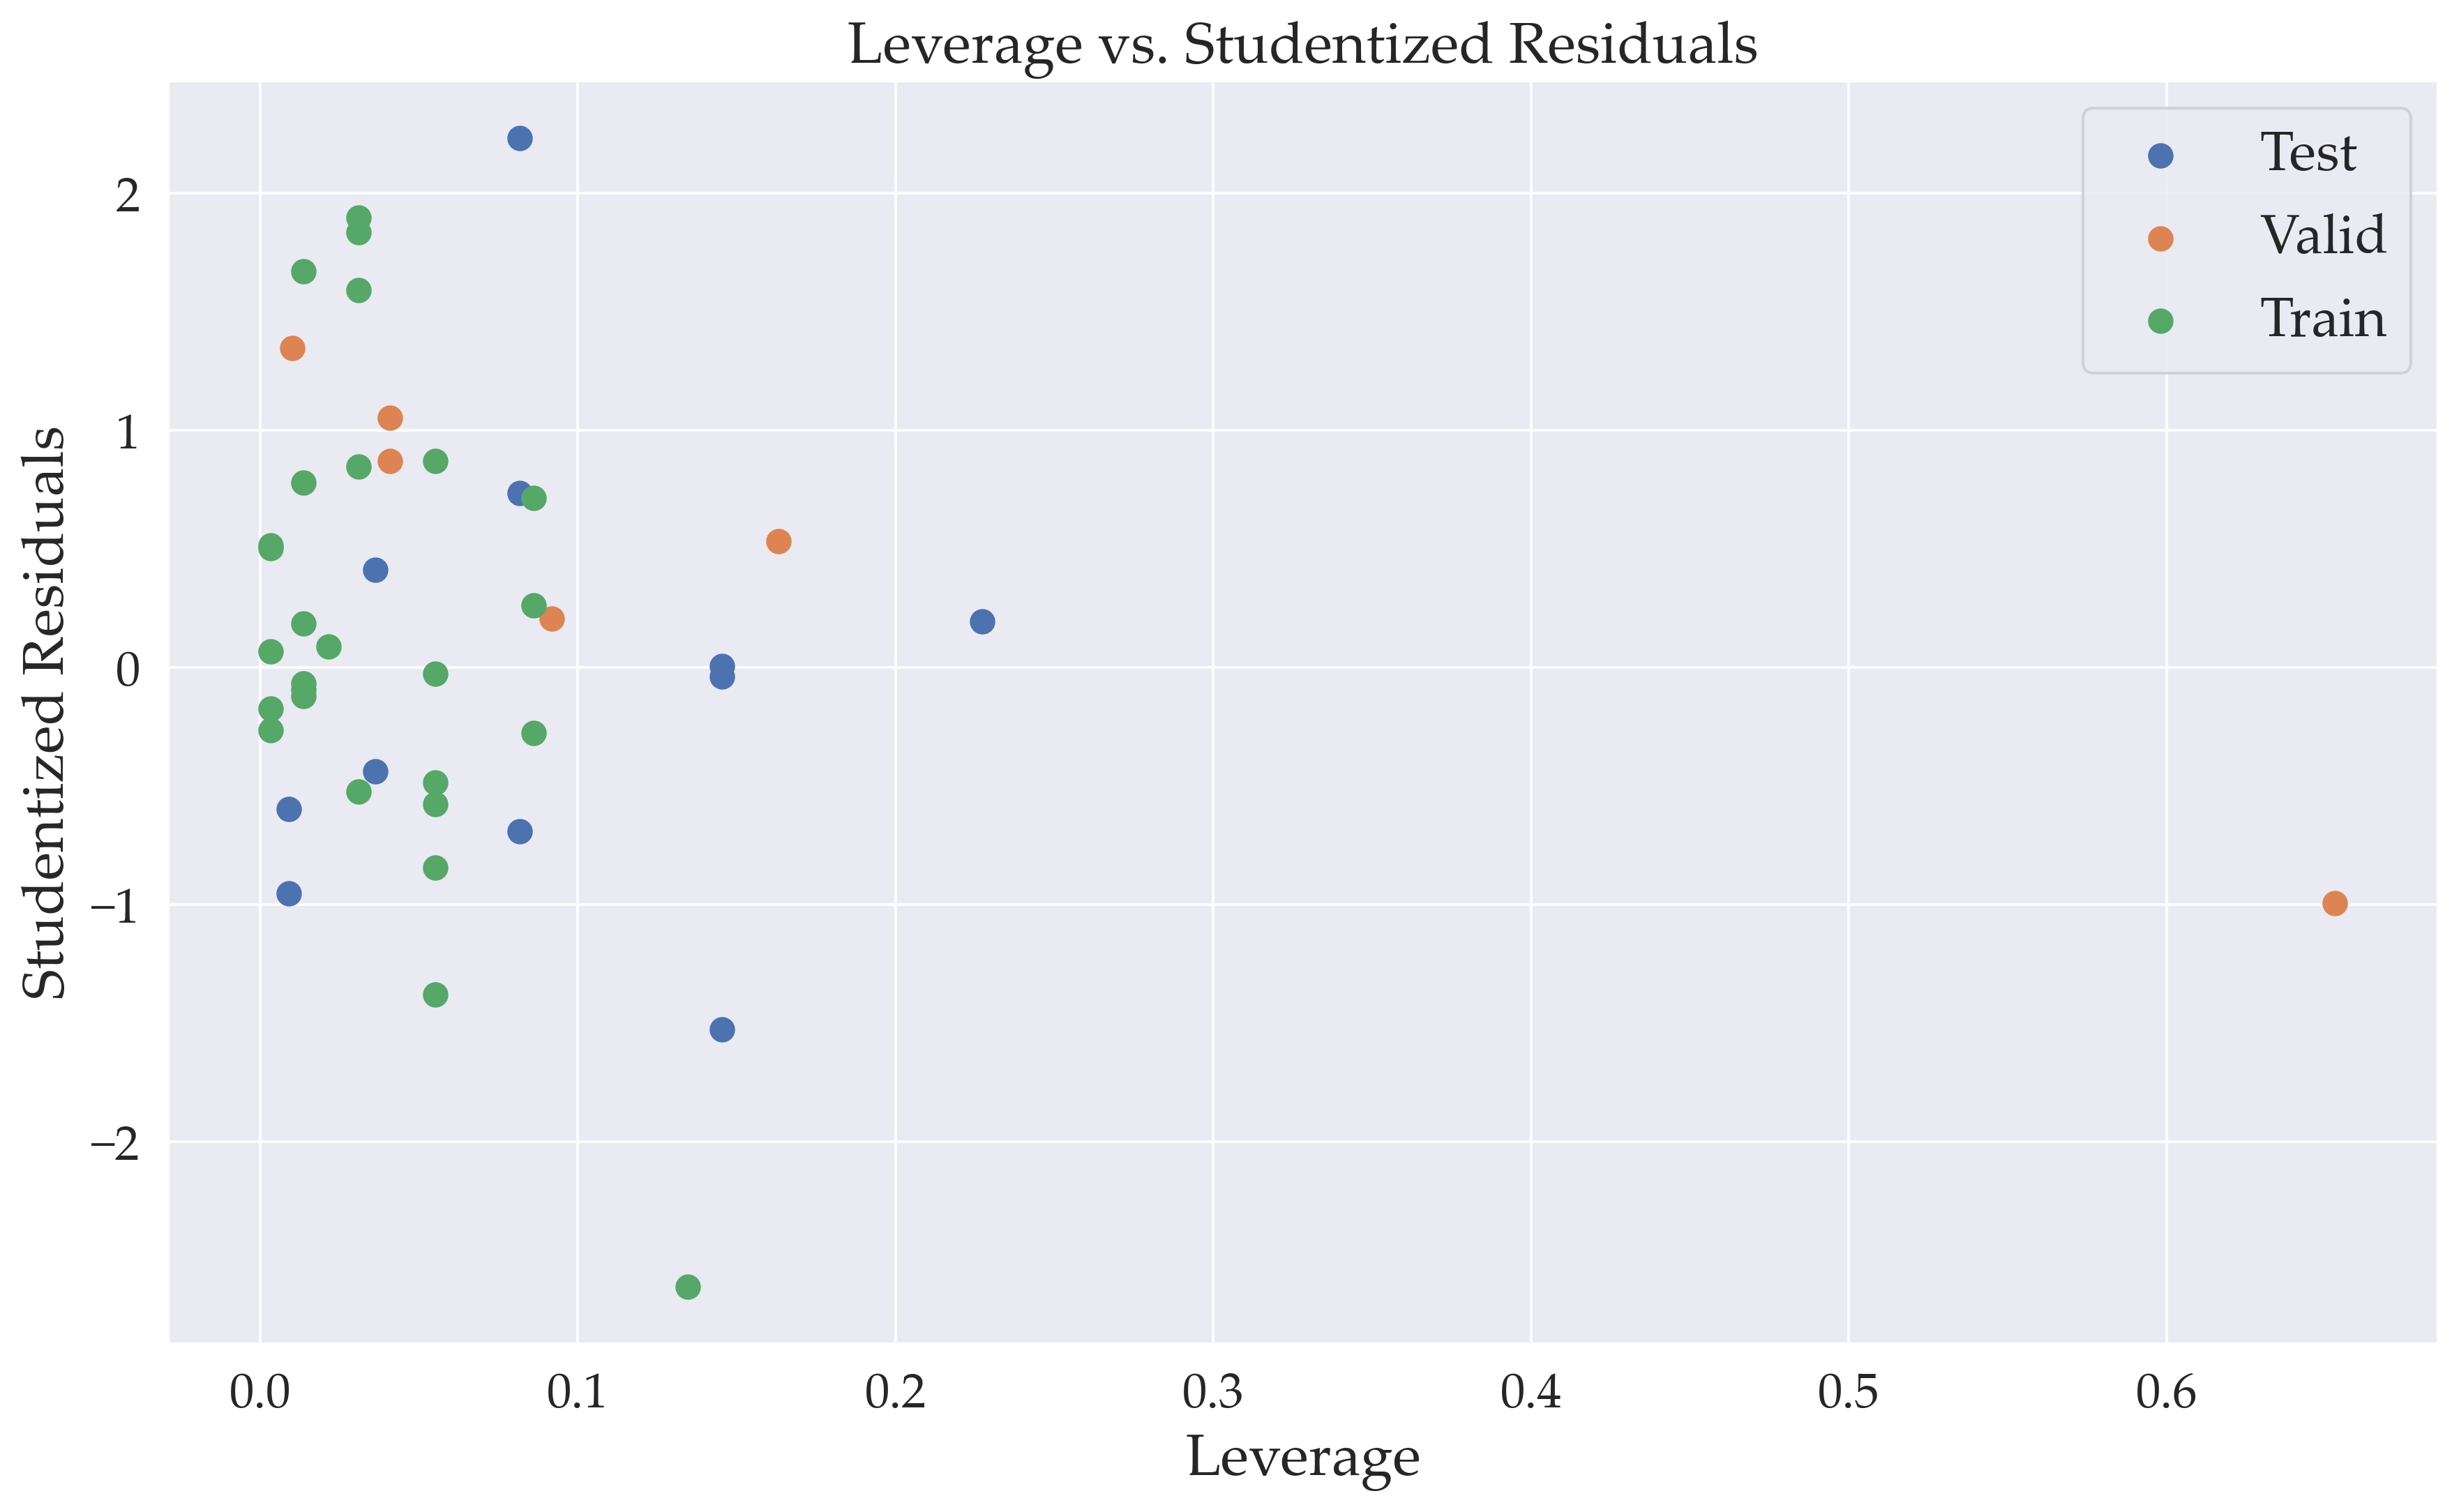

In [158]:
plt.figure(figsize=(14, 8), dpi=300)


exp_metrics_test = get_metrics(final_data_df.loc[final_data_df["Date"] == "2016-08-31"]["ECM_pred"], 
                                final_data_df.loc[final_data_df["Date"] == "2016-08-31"]["Explosive\nCharge Mass"], "Test")

exp_metrics_valid = get_metrics(final_data_df.loc[final_data_df["Date"] == "2015-06-12"]["ECM_pred"], 
                                final_data_df.loc[final_data_df["Date"] == "2015-06-12"]["Explosive\nCharge Mass"], "Valid")

exp_metrics_train = get_metrics(final_data_df.loc[((final_data_df["Date"] == "2014-06-12") | (final_data_df["Date"] == "2016-07-20") )]["ECM_pred"], 
                                final_data_df.loc[((final_data_df["Date"] == "2014-06-12") | (final_data_df["Date"] == "2016-07-20") )]["Explosive\nCharge Mass"], "Train")

explosive_metrics_df = pd.DataFrame([exp_metrics_test, exp_metrics_valid, exp_metrics_train ])

plt.savefig("ECM_leverage.png", dpi=300, bbox_inches='tight')
explosive_metrics_df

In [159]:
metrics_df = pd.concat([explosive_metrics_df, stem_metrics_df], axis = 0)

metrics_df = metrics_df[[ "R2", "MRE"]]

<AxesSubplot:>

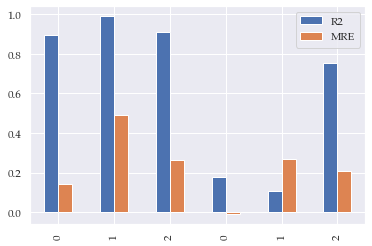

In [160]:
metrics_df.plot.bar()

In [74]:
import statsmodels.formula.api as sm
import scipy.stats as scipystats
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats 

AttributeError: 'Clay_NN' object has no attribute 'get_influence'